# Building a Facial Recognition System with a Siamese Network

### - DIDA 340 Final Project -

### Nathaniel Gilbert, Jeffrey Zheng, & Kristina Donders

#### December 11, 2025

#### [Presentation](https://docs.google.com/presentation/d/1ane3gBjEWW2T-G4AO8BYwRfRYDEMJaZ05BbAtEXNN5o/edit?slide=id.g3ace7b19b97_0_96#slide=id.g3ace7b19b97_0_96)


## Introduction:

As artificial intelligence technology has rapidly improved over the past decade, it's become prevalent across all aspects of society. Specifically, governments and private businesses have exlpored ways that this technology can be used for surveillance through facial recognition. However, while this technology can be used for public safety and crime prevention, it also poses a significant ethics and privacy risk. Thus, using these systems requires caution and human oversight.

In this paper, we will perform an extensive literature review into using facial recognition systems for surveillance, and explore ways that researchers have used siamese networks to create these technologies. Additionally, we will create a facial recognition system with a siamese network and compare our model to other similar models we found online.



## Literature Review:

### [New Orleans AI surveillance cameras: Public safety or privacy violation?](https://tulanehullabaloo.com/71098/data/new-orleans-ai-surveillance-cameras-public-safety-or-privacy-violation/)

Written in mid-October, 2025, this paper ways the pros and cons of the New Orleans Police Department secretly installing AI-driven facial recogntion systems. The goal of these systems were to monitor NOLA's streets for suspects and wanted criminals.

So far, this system seems to have promising results. In 2024, murder rates dropped 23% nationally and 39% in New Orleans. These camersas reduced gun violence in an extremely high-crime area in NOLA by 80%.

However, while these camera's seem to be making New Orleans safer, should they be fully trusted to make decisions regarding a potential suspects fate? Or should human oversight and additional evidence be required in order for a potential suspect to be arrested? These are questions that are both posed in the article. At times, police have arrested suspects solely based on AI matches without additional evidence. This creates the risk of algorithmic bias, in which human biases, like racism, may be hard-coded into these technologies via the datasets that are used to train the model.

Additionally, while these camera's are helpful in public spaces, they present serious concerns about privacy, especially because this data is being collected without the individuals consent. The surveillance company that runs these cameras claim to 'strongly protect people's privacy' by only storing footage for two weeks and not using computer-based predictive behaviour algorithms, however, a recent law in Louisians prohibits law enforcement from purposefully withholding data from U.S. Immigranttion an Custom's enforcement, meaning that data collected by these systems could be misused and put undocumented immigrants at risk.


### [Casino uses facial recognition technology to supplement security](https://journalrecord.com/2022/10/25/casino-uses-facial-recognition-technology-to-supplement-security/)

AI-based facial recognition systems have also been used for security systems in casinos' to help monitor gaming floors. One example of a security system that does this is OnWatch by Oosto. Their goal is to keep track of potential 'bad actors' in real time.

This security system allowed for better tracking of 'persons of interest' through the venue without interfering with guests. On average, around 3-5 potential detection have been made per day since the system was employed.

Beyond strengthening security, these systems can also make players feel more at ease by reducing the need for visible human security guards throughout the venue.


### [Acceptance of AI-powered facial recognition technology in surveillance scenarios: Role of trust, security, and privacy perceptions](https://www.sciencedirect.com/science/article/abs/pii/S0160791X24002690)

Facial recognition technology raises a complicated mix of security benefits, privacy risks, and questions of public trust. Supporters laud its value in public safety, crime prevention, and humanitarian uses like finding missing children. Critics, however, emphasizes concerns like unauthorized data collection, lack of consent, 'function creep,' in which data is being used for reasons different from why it was originally collected, and algorithmic biases that disproportionately misidentify people from certain racial and ethnic groups.

Public opinion tends to see FRT as invasive but unavoidable, reflecting a phenomenon the paper denotes as digital resignation, where privacy feels like the cost of security. The authors note that surveillance itself isn't inherently harmful, but warn against the normalization of intrusive practices without oversight. Ultimately, using FRT requires balancing meaningful security gains with the protection of individual rights in order to maintain public trust.



### [A Siamese-network-based Facial Recognition System](https://sensors.myu-group.co.jp/sm_pdf/SM3678.pdf)

This paper delves into a key limitation of traditional CNN-based facial recognition systems: their inability to handle unknown identities without forcing a prediction, which can lead to dangerous misclassifications. To address this, the authors propose a Siamese network that relies on metric learning rather than fixed-category classification. The model learns embedding representations of faces, where the distance between two embeddings reflects their similarity: small distances indicate the same person, larger distances indicate different people, and a threshold determines the final decision. This architecture is scalable, as adding or removing individuals requires only updating the database rather than retraining the model itself. The authors report strong performance, achieving an accuracy of 96.9%.

## Background
### Overview of a Siamese Network Architecture:
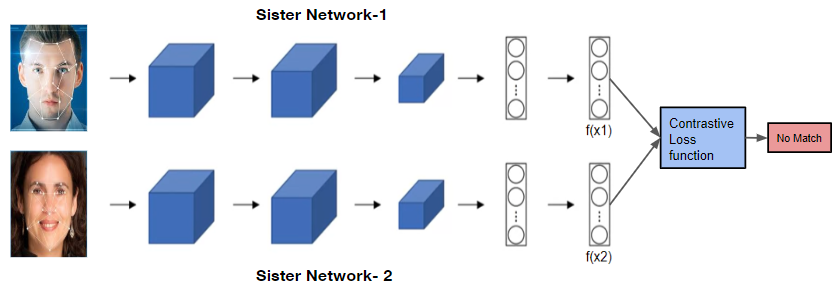

Our model performs the following procedure:

1.   Two input images are fed into two identical 'sister' networks
2.   Each image passes through an identical CNN to extract key features
3.   Features are flattened and passed through fully connected layers
4.   Each network outputs an embedding vector
5.   Vectors are compared using the contrastive loss function
6.   The pair of images is laveled as the same/different person



## Importing Libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from fastai.vision.all import *

# For image augmentation
from PIL import Image
import PIL.ImageOps
from PIL import ImageFilter, ImageEnhance
import tensorflow as tf

# For neural network
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# For saving/loading learn data
import pickle

# For splitting dataset into train/test
from sklearn.model_selection import train_test_split

from functools import partial

## Data Preprocessing:
### Importing our Dataset:

For this project, we used the [Labeled Faces in the Wild database](https://www.kaggle.com/datasets/atulanandjha/lfwpeople/data) on Kaggle, a database of face photographs designed to study the problem of unconstrained face recognition. This dataset contains over 13,000 images of faces collected from the internet. Among these, approximately 1,680 individuals have 2 or more distinct photos in the dataset, allowing for more *meaningful* positive (same person) and negative (different person) pair generation for Siamese training.

In [ ]:
%env KAGGLE_USERNAME=j3ffr3yzh3ng
%env KAGGLE_KEY=c56cf80219f9e2e767197bc961b147ce

!kaggle datasets download -d atulanandjha/lfwpeople
!unzip lfwpeople.zip

env: KAGGLE_USERNAME=j3ffr3yzh3ng
env: KAGGLE_KEY=c56cf80219f9e2e767197bc961b147ce
Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
License(s): GNU Lesser General Public License 3.0
 69% 161M/232M [00:00<00:00, 1.69GB/s]
100% 232M/232M [00:00<00:00, 1.70GB/s]
Archive:  lfwpeople.zip
  inflating: lfw-funneled.tgz        
  inflating: pairs.txt               
  inflating: pairsDevTest.txt        
  inflating: pairsDevTrain.txt       


In [ ]:
# Used for extracting all image files in dataset
import tarfile

path = Path(".")
tar_path = tarfile.open("lfw-funneled.tgz").extractall("", filter = 'fully_trusted')

images = get_image_files(path/"lfw_funneled")
labels = [parent_label(img) for img in images]

### Train-Test Split:
After importing the dataset, it was split into training and testing sets. This was done as there were no parent labels attached to the file names of the images. We implemented a 80/20 split as it was a widely used splitting method and ensured that we had enough data available for training our model.

In [ ]:
# Splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    images, labels,
    test_size=0.2,
    random_state=1)

In [ ]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[222, 239, 233],
        [222, 239, 233],
        [224, 241, 235],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[223, 240, 234],
        [223, 240, 234],
        [225, 242, 236],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[223, 240, 234],
        [224, 241, 235],
        [225, 242, 236],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
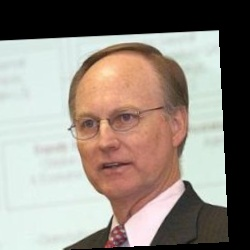

In [ ]:
np.array(Image.open(images[1]))

### Image Augmentation:
Facial images that are captured in real-world surveillance settings are often distorted various ways, as images captured by cameras can vary depending on distance from the camera and the resolution of the camera. Additionally, factors such as low lighting and visibility have an impact on the quality of these images.

To make the model robust to such variations, a series of augmentation techniques were applied to the images. Notably, the augmentation function we defined had randomly flipped, blurred, and rotated images in order to simulate some variation that can occur.

Furthermore, these augmentations proved to be more valuable for handling cases in the dataset where individuals only had one distinct image available. By generating variations to these specific cases, it allows the model to learn a more generalized understanding of each face, improving the ability to correctly identity and differentiate two images.

In [ ]:
from fastai.vision.augment import brightness
def augment_image(image):

  # Chance for image to flip
  if random.random() < 0.5:
    image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

  # Random rotation for image
  angle = random.randint(-30,30)
  image = image.rotate(angle, expand = False, fillcolor = (0,0,0))

  # Random blur to image
  image = image.filter(ImageFilter.BoxBlur(random.randint(4,8)))

  return image

### Pair Generation (Dataset for Siamese Network):
We then made a function that, when a dataset is inputted, randomly picks an image and partner image, loads both images, applies the augmentation function we previously defined, converts the images to tensors that can be understood by Python, and returns a label corresponding to if the images are the same or different people.

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        # Pick a random anchor image index
        img0_idx = random.randint(0, len(self.images) - 1)
        img0_path = self.images[img0_idx]
        img0_data = np.array(Image.open(img0_path))
        label0 = self.labels[img0_idx]

        should_get_same_class = random.randint(0, 1)

        if should_get_same_class:
            # Find an image from the same class, but not the same instance
            same_class_indices = [i for i, label in enumerate(self.labels) if label == label0 and i != img0_idx]
            if not same_class_indices:
                # Fallback if only one image exists for the class, should not happen with min_faces_per_person=2
                img1_idx = img0_idx # As a last resort, use the same image
            else:
                img1_idx = random.choice(same_class_indices)
            img1_path = self.images[img1_idx]
            img1_data = np.array(Image.open(img1_path))
            target = 0.0 # Same class
        else:
            # Find an image from a different class
            diff_class_indices = [i for i, label in enumerate(self.labels) if label != label0]
            # This list should almost never be empty in a multi-class dataset
            if not diff_class_indices:
                # Fallback, if for some reason no different class images are found
                img1_idx = random.randint(0, len(self.images) - 1) # Pick any random image
            else:
                img1_idx = random.choice(diff_class_indices)
            img1_path = self.images[img1_idx]
            img1_data = np.array(Image.open(img1_path))
            target = 1.0 # Different class


        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)

        img0 = img0.filter(ImageFilter.DETAIL)
        img1 = augment_image(img1) # Augment only one image

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([target], dtype=np.float32))

    def __len__(self):
        return len(self.images)

In [ ]:
# Transformation used to resize all images to a standard size and
#  converts the images into a tensor to be used in the CNN (feature extractor)
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Define the training dataset that can be used in Siamese network
siamese_dataset = SiameseNetworkDataset(images=X_train,
                                        labels=y_train,
                                        transform=transformation)

Then, we built a dataloader that feeds the model mini-batches or paried images during training. This dataloader takes the Siamese dataset as an input, creates batches of 8 image pair, and randomizes the order of images each epoch. Finally, it uses 2 CPU threads for faster loading to make the determination of whether each pair of images is the same or different people.

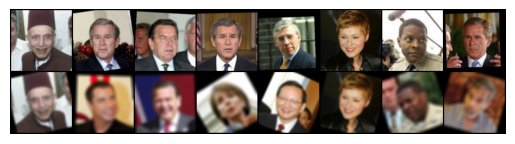

[0. 1. 0. 1. 1. 0. 0. 1.]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Visual inspection of a sample batch of images
#  ensuring that the model functions properly
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

## Building the Siamese Network:
### Model Architecture of the Twin Network:
When constructing our Siamese Network we incorporated the following 3 components:
1. CNN Layer (Feature Extractor) \
 Each image is passed through a CNN to extract prominent features. This layer is used to intake raw pixel information and transform it into a compact representation.  \
 It includes:
   - Convolution layers that detect these prominent features by observing patters such as edges, corners, textures, and shapes
   - ReLu activation functions to introduce non-linearity into the model
   - Max pooling layers to control overfitting by reducing the spatial dimension of the feature map and also emphasizing the most prominent features

2. Fully Connected Layer (Dense Layer) \
 Intakes a flattened feature vector from the CNN layer to further compress and refine the representation of the image's features. \
 It includes:
    - Linear layers that compare and combine the extracted features, and condenses it into smaller embedding vector
    - ReLu activation functions to again help the model learn complex non-linear relationships
    - Dropout layers to reduce the overfitting in the model by randomly deactivating nodes

3. Distance Function \
 Measures the difference between the embedding vectors for the pairs of images, this distance allows for the determination on whether the two images are of the same person or not. \
 The distance function used is the Euclidean distance, which performs the following calculation: $$D_i = dist(x,y) = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$
 This distance is then used in the contrasitive loss function.



In [ ]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU()
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(),
            nn.Dropout(p = 0.2),

            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.2),

            nn.Linear(256,128)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) # Flattens the output of the CNN
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # Defined the euclidean distance between the two output vectors
        # Allows for the use of fastAI
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        return euclidean_distance

### Contrasitive Loss Function:
Following the twin sister networks, we built a contrastive loss function.

This type of loss function is special to Siamese networks, and teaches the model to tell whether two images are similar or different. It makes the network cluster same-people faces together by pulling the embeddings closer and separate different-person faces by pushing the embeddings away.

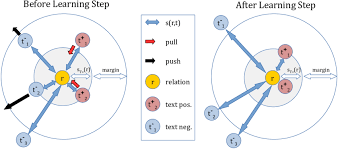

In particular, the loss function utilizes the Euclidean distance and a margin parameter to make such adjustments. For images of the same person, the loss function will increase if the embeddings are farther apart; and for images of different people, the loss function will increase if the embeddings are closer together.
The function performs the following equation:
$$ loss = \frac{1}{n} (\sum_{i=1}^{n} (1- y_i) \cdot (D_i)^2 + y_i \cdot max(0, margin - D_i)^2 )$$ where $y_i$ denotes the label value (0 for same, 1 for different), $D_i$ is the Euclidean distance, and margin sets the minimum distance for disimilar pairs (default set to 10).

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin = 10.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, euclidean_distance, label):
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

      return loss_contrastive

### Accuracy Metric:
Next, we build an accuracy function for our Siamese network.

Since our model returns the distance between pairs, not an actual prediction (this is done during the contrastive loss function), we need to define an accuracy measure that creates a prediction.

To do this, we set a threshold. If the distance is greater than that threshold for a given pair of images, it returns 1, which corresonds to a label of different people.

To find the optimal threshold, we test through a range of thresholds in a range and store the one with the best accuracy.

In our case, the best threshold was 3.6935.

In [ ]:
def siamese_acc(preds, targs, thresh:float = 1.0):

    tgt = targs.view(-1).long()

    pred_labels = (preds > float(thresh)).long().view(-1)

    pred_labels = pred_labels.to(tgt.device)

    acc = (pred_labels == tgt).float().mean()
    return acc

## Training the full model:

We then augmented the training data to improve the robustness of the model. First, we normalized the testing data. Then, we created a training and testing siamese dataset and loaded them both into a DataLoader.

In [ ]:
# Redefine the train dataset
siamese_dataset = SiameseNetworkDataset(images=X_train,
                                        labels=y_train,
                                        transform=transformation)

train_size = int(len(siamese_dataset) * 0.8)
valid_size = len(siamese_dataset) - train_size

train_ds, val_ds = random_split(siamese_dataset, [train_size, valid_size])

batch_size = 64

dls = DataLoaders.from_dsets(
    train_ds,
    val_ds,
    bs=batch_size,
    shuffle_Train=True,
    shuffle_valid=False,
    num_workers=0,
    item_tfms=[
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
acc_metric = partial(siamese_acc)

In [ ]:
learn = Learner(
    dls = dls,
    model = net,
    loss_func = criterion,
    opt_func = Adam,
    metrics = partial(siamese_acc, thresh=3.625)
)

SuggestedLRs(valley=0.0004786300996784121)

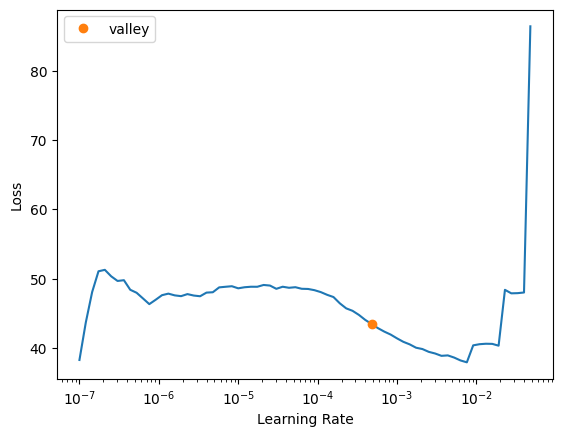

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 0.001)

epoch,train_loss,valid_loss,siamese_acc,time
0,22.128357,22.840933,0.686969,01:19
1,22.314941,26.974709,0.643532,01:20
2,20.240797,20.464594,0.708215,01:20
3,19.618227,18.202761,0.740793,01:20
4,18.511232,17.541857,0.729934,01:19
5,17.932014,18.204378,0.731350,01:19
6,17.579559,16.609859,0.749292,01:19
7,16.131563,16.092695,0.758263,01:20
8,17.195311,15.360827,0.769594,01:20
9,16.447838,15.567285,0.773843,01:19


## Analysis:

After training for 10 epochs, we achieved an accuracy of 77.38.
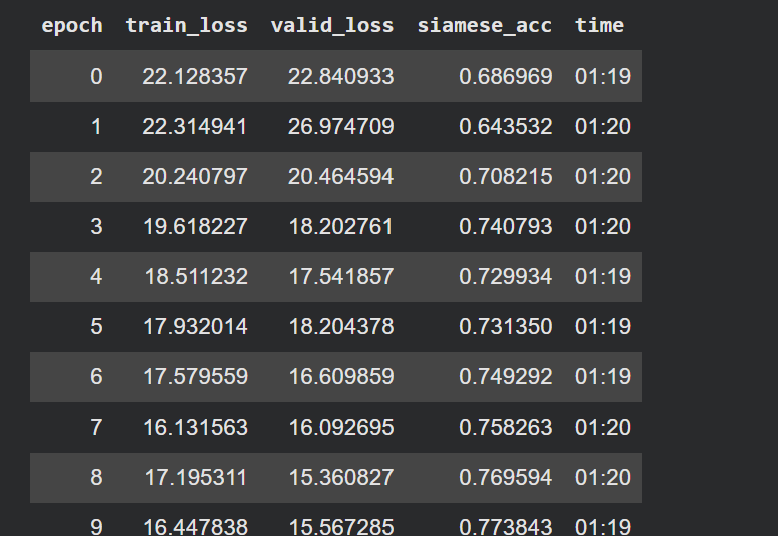

Now, we compare this accuracy measure to the accuracy's of Kaggle members who also made siamese networks to perform facial recognition on the labeled faces in the wild dataset. Their scores were: 66.35%, 75.78%, 54.7%, and 70.31%. Our accuracy of 77.38% is higher than all of those scores.

When compared to the 96% accuracy achieved in the paper we reviewed, our model’s performance is noticeably weaker.

Altogether, given our time constraints and limited computation power, we are happy with how our model performed.

## Conclusion & Discussion

Overall, we are happy with how our model performed. However, when we compare our model to the literature we based our model off of, which achieved an accuracy score of 96%, it's clear that our siamese network has room for improvement.

For future researh, this model could potentially be improved by training the model for more epochs or by adjusting the contrastive loss margin. We could also experiment with more data augmentation methods to help the model learn more distinct embeddings. This could be done by fine-tuning the hyperparameters (i.e. randomly rotating, cropping, adding noise to, blurring, shifting, or flipping images).

Finally, we can't talk about building a facial recognition system without recognizing their ethical concerns. While building a facial recognition system with a siamese network was an interesting challenge, using systems like these in the real world demands caution. Even though surveillance isn't inherently abusive, history shows that these systems are closely tied to misuse, making ethical safeguards and mandated regulation essential.